In [1]:
import numpy as np
from scipy import linalg as la
from scipy.sparse import spdiags
from cvxopt import matrix, solvers
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

This notebook explores interior point methods for quadratic, convex objective functions that involve positive semidefinite quadratic terms. This makes our optimization problem the following (note the absence of equality constraints now): 

minimize $ \frac{1}{2}x^TQx+c^Tx $ subject to $ Ax \geq b $ 

I apply the interior point class to two problems below, elastic membrane optimization and Markowitz Portfolio allocation. 

In [ ]:
def startingPoint(G, c, A, b, guess):
    """
    Obtain an appropriate initial point for solving the QP
    .5 x^T Gx + x^T c s.t. Ax >= b.
    Parameters:
        G -- symmetric positive semidefinite matrix shape (n,n)
        c -- array of length n
        A -- constraint matrix shape (m,n)
        b -- array of length m
        guess -- a tuple of arrays (x, y, mu) of lengths n, m, and m, resp.
    Returns:
        a tuple of arrays (x0, y0, l0) of lengths n, m, and m, resp.
    """
    m, n = A.shape
    x0, y0, l0 = guess

    # Initialize linear system
    N = np.zeros((n+m+m, n+m+m))
    N[:n,:n] = G
    N[:n, n+m:] = -A.T
    N[n:n+m, :n] = A
    N[n:n+m, n:n+m] = -np.eye(m)
    N[n+m:, n:n+m] = np.diag(l0)
    N[n+m:, n+m:] = np.diag(y0)
    rhs = np.empty(n+m+m)
    rhs[:n] = -(G.dot(x0) - A.T.dot(l0)+c)
    rhs[n:n+m] = -(A.dot(x0) - y0 - b)
    rhs[n+m:] = -(y0*l0)

    sol = la.solve(N, rhs)
    dx = sol[:n]
    dy = sol[n:n+m]
    dl = sol[n+m:]

    y0 = np.maximum(1, np.abs(y0 + dy))
    l0 = np.maximum(1, np.abs(l0+dl))

    return x0, y0, l0


In [2]:
# Quadratic Interior Point method 
def qInteriorPoint(Q, c, A, b, guess, niter = 20, tol = 1e-16, verbose = False):
    """
    Solve the Quadratic program 
    
    min: .5 x^T Q x +  c^T x, 
    subject to: Ax >= b
    
    using an Interior Point method.

    Parameters:
        Q ((n,n) ndarray): Positive semidefinite objective matrix.
        c ((n, ) ndarray): linear objective vector.
        A ((m,n) ndarray): Inequality constraint matrix.
        b ((m, ) ndarray): Inequality constraint vector.
        guess (3-tuple of arrays of lengths n, m, and m): Initial guesses for
            the solution x and lagrange multipliers y and eta, respectively.
        niter (int > 0): The maximum number of iterations to execute.
        tol (float > 0): The convergence tolerance.

    Returns:
        x ((n, ) ndarray): The optimal point.
        val (float): The minimum value of the objective function.
    """
    m, n = A.shape 
    # only need to save shape of A 
    # since Q is n x n and y, mu, b in R^m
    
    e = np.ones(m) # vector of all ones 
    
    def F(x, y, mu): 
        """
        Returns KKT conditions for Lagrangian
        """
        Y, M = np.diag(y), np.diag(mu)
        return np.concatenate([Q @ x - A.T @ mu + c, A @ x - b - y, Y @ M @ e])
    
    
    def search_direction(x, y, mu): 
        """
        Solves the search-direction problem from equation (16.2)
        via LU decomposition of matrices 
        """
        sigma = 0.1 # centering parameter 
        zeros = np.zeros(m + n)
        Y, M = np.diag(y), np.diag(mu)
        v = (y.T @ mu) / m # duality measure 
        
        # perturbation vector 
        vector = np.concatenate((zeros, e)) * sigma * v # might need to change dimensions here
        right = -F(x, y, mu) + vector
        
        # diagonalize x, mu to create DF 
        X, M = np.diag(x), np.diag(mu)
        
        # components to create DF 
        zeros_mm = np.zeros((m, m)) # m x m square 
        zeros_nm = np.zeros((n, m)) # n X m ==> zeros_nm.T is m x n 
        I = np.eye(m) # we negate this to get -I 
        
        top = np.hstack((Q, zeros_nm, -A.T))   # top row 
        mid = np.hstack((A, -I, zeros_mm))     # mid row 
        bottom = np.hstack((zeros_nm.T, M, Y)) # bottom row 
        
        # stack to create DF 
        DF = np.vstack((top, mid, bottom))
        
        # factor with LU and solve 
        L, P = la.lu_factor(DF)
        soln = la.lu_solve((L, P), right)
        
        # divvy up the individual vectors 
        del_x = soln[:n]
        del_y = soln[n: n + m]
        del_mu = soln[n + m:]
        
        # return the del's 
        return del_x, del_y, del_mu
        
        
    def step_size(x, y, mu): 
        """
        Calculate the max-allowable step sizes while still staying
        in the feasible region of the problem 
        """
        Y, M = np.diag(y), np.diag(mu)
        # retrieve del's from search direction function 
        del_x, del_y, del_mu = search_direction(x, y, mu)
        
        # mask where we find appropriate alpha 
        mask = np.where(del_mu < 0)
        b = min(-mu[mask] / del_mu[mask])
        beta = min(1, 0.95 * b)
        
        # mask where we find appropriate delta 
        mask = np.where(del_y < 0)
        d = min(-y[mask] / del_y[mask])
        delta = min(1, 0.95 * d)
        
        # take alpha as min of these two parameters 
        alpha = min(beta, delta)
        
        # return the updated step sizes 
        return alpha * del_x, alpha * del_y, alpha * del_mu
    
    
    # get initial starting point from auxiliary
    x0, y0, mu0 = startingPoint(Q, c, A, b, guess)
    
    # run optimizer !! 
    for i in range(niter): 
        
        step_x, step_y, step_mu = step_size(x0, y0, mu0)
        
        x1 = x0 + step_x
        y1 = y0 + step_y
        mu1 = mu0 + step_mu
        
        # update duality measure 
        v = (y1.T @ mu1) / m
        
        print("Iteration {} - Duality Measure {}".format(i, v))
        
        # if duality measure is less than tol
        # in other words, if we are close enough to the optimizer 
        if v < tol: 
            break 
    
        # update our " parameters "
        x0, y0, mu0 = x1, y1, mu1
       
    # return optimizer x1 and falue given x1 
    return x1, c.T @ x1
        

In [3]:
# quick unit test to make sure this works 

Q = np.array([[1, -1], [-1, 2]])
c = np.array([-2, -6])
b = np.array([-2, -2, -3, 0, 0])
A = np.array([[-1, -1], [1, -2], [-2, -1], [1, 0], [0, 1]])
m, n = A.shape 
x = np.array([-.5, -.5])

guess = (x, np.ones(m), np.ones(m))

qInteriorPoint(Q, c, A, b, guess)

Iteration 0 - Duality Measure 0.2504667807968671
Iteration 1 - Duality Measure 0.1260034199885806
Iteration 2 - Duality Measure 0.0428048440471998
Iteration 3 - Duality Measure 0.006051624858735472
Iteration 4 - Duality Measure 0.0006586202057219926
Iteration 5 - Duality Measure 6.620915093970022e-05
Iteration 6 - Duality Measure 6.622944665250614e-06
Iteration 7 - Duality Measure 6.623135652761782e-07
Iteration 8 - Duality Measure 6.62315466912704e-08
Iteration 9 - Duality Measure 6.623156569975102e-09
Iteration 10 - Duality Measure 6.623156760052036e-10
Iteration 11 - Duality Measure 6.623156779059655e-11
Iteration 12 - Duality Measure 6.623156780960395e-12
Iteration 13 - Duality Measure 6.623156781150459e-13
Iteration 14 - Duality Measure 6.623156781169464e-14
Iteration 15 - Duality Measure 6.623156781171365e-15
Iteration 16 - Duality Measure 6.62315678117156e-16
Iteration 17 - Duality Measure 6.62315678117158e-17


(array([0.66666667, 1.33333333]), -9.333333333333334)

In [4]:
def laplacian(n):
    """
    Construct the discrete Dirichlet energy matrix H for an n x n grid
    """
    data = -1*np.ones((5, n**2))
    data[2,:] = 4
    data[1, n-1::n] = 0
    data[3, ::n] = 0
    diags = np.array([-n, -1, 0, 1, n])
    return spdiags(data, diags, n**2, n**2).toarray()


def circus(n = 15):
    """
    Solve the circus tent problem for grid size length 'n'.
    Display the resulting figure.
    """
    # Create the tent pole configuration.
    L = np.zeros((n,n))
    L[n//2-1:n//2+1,n//2-1:n//2+1] = .5
    m = [n//6-1, n//6, int(5*(n/6.))-1, int(5*(n/6.))]
    mask1, mask2 = np.meshgrid(m, m)
    L[mask1, mask2] = .3
    L = L.ravel()
    
    # Set initial guesses.
    x = np.ones((n, n)).ravel()
    y = np.ones(n**2)
    mu = np.ones(n**2)
    
    # Calculate the solution.
    H = laplacian(n)
    c = np.ones(n**2) / (-(n - 1)**2)
    A = np.eye(n**2)
    z = qInteriorPoint(H, c, A, L, (x, y, mu))[0].reshape((n, n))
    
    # Plot the solution.
    domain = np.arange(n)
    X, Y = np.meshgrid(domain, domain)
    fig = plt.figure(figsize = (11, 7), dpi = 125)
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.plot_surface(X, Y, z, rstride=1, cstride=1, color='r', alpha = 0.85)
    
    plt.show()
    

Iteration 0 - Duality Measure 0.14246787705325453
Iteration 1 - Duality Measure 0.032457137687800494
Iteration 2 - Duality Measure 0.009857649500875969
Iteration 3 - Duality Measure 0.0029559499081747076
Iteration 4 - Duality Measure 0.0019625603730144556
Iteration 5 - Duality Measure 0.001187993483401118
Iteration 6 - Duality Measure 0.0005933332954588385
Iteration 7 - Duality Measure 0.00021140497003427746
Iteration 8 - Duality Measure 4.299443308907308e-05
Iteration 9 - Duality Measure 6.192750280848736e-06
Iteration 10 - Duality Measure 6.809047916289453e-07
Iteration 11 - Duality Measure 7.701218368148742e-08
Iteration 12 - Duality Measure 8.818479005237874e-09
Iteration 13 - Duality Measure 8.81910911933553e-10
Iteration 14 - Duality Measure 8.819170837294291e-11
Iteration 15 - Duality Measure 8.819177008587088e-12
Iteration 16 - Duality Measure 8.819177625712563e-13
Iteration 17 - Duality Measure 8.819177687425106e-14
Iteration 18 - Duality Measure 8.819177693596308e-15
Iteratio

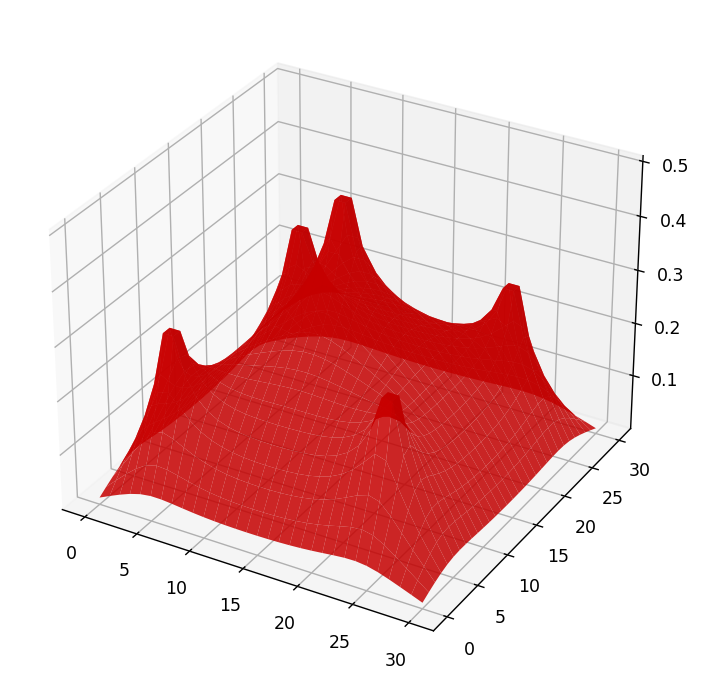

In [5]:
circus(n = 31)

In [6]:
def portfolio(filename = "portfolio.txt", R = 1.13):
    """
    Markowitz Portfolio Optimization

    Parameters:
        filename (str): The name of the portfolio data file.
        R (float): The desired rate of return for the portfolio (1.13 => 13% return desired)

    Returns:
        (ndarray) The optimal portfolio with short selling.
        (ndarray) The optimal portfolio without short selling.
    """
    # load data and strip dates off in first collumn 
    data = np.loadtxt(filename)[:, 1: ]
    
    # define covariance 
    # matrix for the 8 assets 
    Q = matrix(np.cov(data.T))
    mu = np.mean(data, axis = 0)
    r = matrix(np.zeros(8))
     
    # equality constraints 
    # AND SPECIFY DESIRED RETURN R
    A = matrix(np.vstack((np.ones(8), mu)))
    b = matrix(np.array([1, R])) # specify here 
    
    solvers.options['show_progress'] = False 
    
    # solution to short problem 
    sol = solvers.qp(Q, r, A = A, b = b)
    optimal_short_x = np.ravel(sol["x"])
    
    # solution to non-short problem 
    G = matrix(-1*np.eye(8))
    h = matrix(np.zeros(8))
    
    sol = solvers.qp(Q, r, G, h, A, b)
    optimal_no_short_x = np.ravel(sol["x"])
    
    return optimal_short_x, optimal_no_short_x


In [7]:
short, no_short = portfolio()

print("Optimal Portfolio Allocation With Shorting: \n{}\n".format(short))
print("Optimal Portfolio Allocation Without Shorting: \n{}".format(no_short)) 

Optimal Portfolio Allocation With Shorting: 
[-1.34200673 -1.54883275 -1.45442804  1.63917661 -0.38997801  3.60572152
  0.28283405  0.20751336]

Optimal Portfolio Allocation Without Shorting: 
[1.69562020e-07 4.49526709e-07 9.94459305e-05 3.88011711e-01
 1.30038772e-07 2.92869996e-02 3.42128859e-01 2.40472236e-01]
